# Preliminary operations

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/Homework1

/gdrive/MyDrive/Homework1


In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip install visualkeras
import visualkeras

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 4.5 MB/s 
2.9.2


# Common definitions

In [4]:
aug_generator = ImageDataGenerator(rotation_range=180,
                                    zoom_range=0.2,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    brightness_range=[0.6,1.4],
                                    fill_mode='reflect',
                                    horizontal_flip=False,
                                    vertical_flip=False,
                                    #rescale=1/255.,
                                    preprocessing_function=None, #Included in the NN
                                   )

In [5]:
def define_generators(directory, bs, aug_gen):

  """ Definition of generators"""

  generators = {}
  training_dir = os.path.join(directory, 'train') 
  validation_dir = os.path.join(directory, 'val') 
  test_dir = os.path.join(directory, 'test') 

  generators['train'] = aug_gen.flow_from_directory(directory=training_dir,
                                                        target_size=(96,96),
                                                        color_mode='rgb',
                                                        classes=None,
                                                        class_mode='categorical',
                                                        batch_size=bs,
                                                        shuffle=True,
                                                        seed=seed)


  # VALIDATION SET
  generators['val'] = ImageDataGenerator(#rescale=1/255.
                                         ).flow_from_directory(directory=validation_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=None,
                                                class_mode='categorical',
                                                batch_size=bs,
                                                shuffle=False,
                                                seed=seed)

  # TEST SET
  generators['test'] = ImageDataGenerator(#rescale=1/255.
                                          ).flow_from_directory(directory=test_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=None,
                                                class_mode='categorical',
                                                batch_size=bs,
                                                shuffle=False,
                                                seed=seed)

  return generators

In [6]:
labels = {
    0:'Species1', 
    1:'Species2', 
    2:'Species3', 
    3:'Species4', 
    4:'Species5', 
    5:'Species6',
    6:'Species7', 
    7:'Species8'}

In [7]:
input_shape = (96, 96, 3)
output_dim = 8
epochs = 200
mtrcs = ['accuracy']
monmtr = 'val_accuracy'

In [8]:
def evaluate_model(model_name, test_set, target):

  """ Function used to evaluate model's performances on the local test set, display of confusion matrix """
  
  model = tfk.models.load_model(model_name)
  predictions = model.predict(test_set)
  metrics= {
    "model": model_name,
    "predictions" : predictions,
    "target": target,
    "cm": confusion_matrix(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), normalize='true', ),
    "accuracy" : accuracy_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1)),
    "precision" : precision_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "recall" : recall_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "f1" : f1_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro')  }
  
  print("Model: "+ str(metrics["model"]))
  print("Accuracy: "+ str(metrics["accuracy"]))
  print("F1 score: "+ str(metrics["f1"]))
  cm = metrics["cm"]
  plt.figure(figsize=(10,8))
  sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=list(labels.values()), yticklabels=list(labels.values()))
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  return metrics

In [9]:
dataset_dir = "dataset_homework1"
bs = 64

In [10]:
gens = define_generators(dataset_dir, bs, aug_generator)

train_gen = gens['train']
valid_gen = gens['val']
test_gen = gens['test']

train_target = train_gen.classes
val_target = valid_gen.classes
test_target = test_gen.classes

train_target_cat = tfk.utils.to_categorical(train_gen.classes)
val_target_cat = tfk.utils.to_categorical(valid_gen.classes)
test_target_cat = tfk.utils.to_categorical(test_gen.classes)

Found 2829 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.


# Model definition

In [12]:
def conv_block(input, filters, dropout):
  
  """ With this function we define the convolutional block used in the model"""

  x = tfkl.Conv2D(
      filters= filters,
      kernel_size=(3, 3),
      strides = (1, 1),
      padding = 'same',
      kernel_initializer = tfk.initializers.HeUniform(seed)
  )(input)
  x = tfkl.BatchNormalization()(x)
  x = tfkl.ReLU()(x)

  x = tfkl.Conv2D(
      filters= filters,
      kernel_size=(3, 3),
      strides = (1, 1),
      padding = 'same',
      kernel_initializer = tfk.initializers.HeUniform(seed)
  )(input)
  x = tfkl.BatchNormalization()(x)
  x = tfkl.ReLU()(x)

  x = tfkl.MaxPooling2D(pool_size = (2, 2))(x)
  d1 = tfkl.Dropout(dropout, seed=seed)(x)

  return x

In [13]:
def build_model_A(input_shape, dropout_rate, lr, lmbd):
    
    """ Function that stacks multiple conv_block defined above to build our scratch model"""
    
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.BatchNormalization()(input_layer)

    x = conv_block(input_layer, 32, dropout_rate)
    x = conv_block(x, 64, dropout_rate)
    x = conv_block(x, 128, dropout_rate)
    x = conv_block(x, 256, dropout_rate)
    x = conv_block(x, 512, dropout_rate)

    #x = tfkl.Flatten(name='Flatten')(x)
    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dropout(dropout_rate, seed=seed)(x)

    x = tfkl.Dense(
        units=256, 
        name='Classifier', 
        kernel_initializer=tfk.initializers.HeUniform(seed), 
        kernel_regularizer=tf.keras.regularizers.l2(lmbd),
        #kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda),
        activation='relu')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed)(x)

    output_layer = tfkl.Dense(
        units=output_dim, 
        name='output_layer',
        activation='softmax',
        kernel_regularizer=tf.keras.regularizers.l2(lmbd),
        #kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda),
        kernel_initializer=tfk.initializers.GlorotUniform(seed)
        )(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(lr), metrics=mtrcs)

    # Return the model
    return model

# Training

## 1. Unbalanced dataset with class weights

First we trained the network with an unbalance dataset using a weighted loss

In [14]:
dataset_dir = "dataset_homework1"
bs = 64

In [15]:
gens = define_generators(dataset_dir, bs, aug_generator)

train_gen = gens['train']
valid_gen = gens['val']
test_gen = gens['test']

train_target = train_gen.classes
val_target = valid_gen.classes
test_target = test_gen.classes

train_target_cat = tfk.utils.to_categorical(train_gen.classes)
val_target_cat = tfk.utils.to_categorical(valid_gen.classes)
test_target_cat = tfk.utils.to_categorical(test_gen.classes)

Found 2829 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.


In [17]:
train_target

array([0, 0, 0, ..., 7, 7, 7], dtype=int32)

In [ ]:
from sklearn.utils import  compute_class_weight
class_weights =  compute_class_weight(class_weight = "balanced",
                              classes = np.unique(train_target),
                              y = train_target)
class_weights = dict(zip(np.unique(train_gen.classes), class_weights))

class_weights #import of the weights using sklearn, before we also used the ratio between the total number of images in the set over the numbers of images in each class 

{0: 2.389358108108108,
 1: 0.8320588235294117,
 2: 0.8583131067961165,
 3: 0.8667279411764706,
 4: 0.8340212264150944,
 5: 1.9978813559322033,
 6: 0.8243006993006993,
 7: 0.8709975369458128}

### Visualize weights

Text(0.5, 1.0, 'Weights')

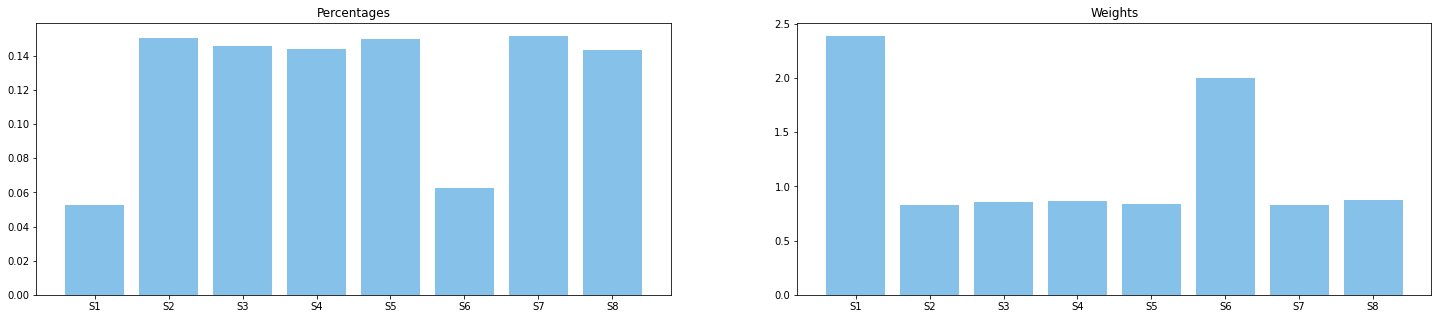

In [ ]:
unique, counts = np.unique(train_target, return_counts=True)
tc = dict(zip(unique, counts/2829))
labels = ['S1', 'S2', 'S3','S4','S5','S6','S7','S8']

size, scale = 1000, 10
fig , (ax1 , ax2) = plt.subplots(1, 2, figsize=(25,5))
values = list(tc.values())
ax1.bar(x=labels,height=values, facecolor ='#85c1e9'); ax1.set_title("Percentages")
values = list(class_weights.values())
ax2.bar(x=labels,height=values, facecolor ='#85c1e9'); ax2.set_title("Weights")

### Training

In [ ]:
dropout_rate = 0.2
lr = 1e-4
l2 = 1e-5

In [ ]:
# Build model 
model = build_model_A(input_shape, dropout_rate, lr, l2)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        18496 

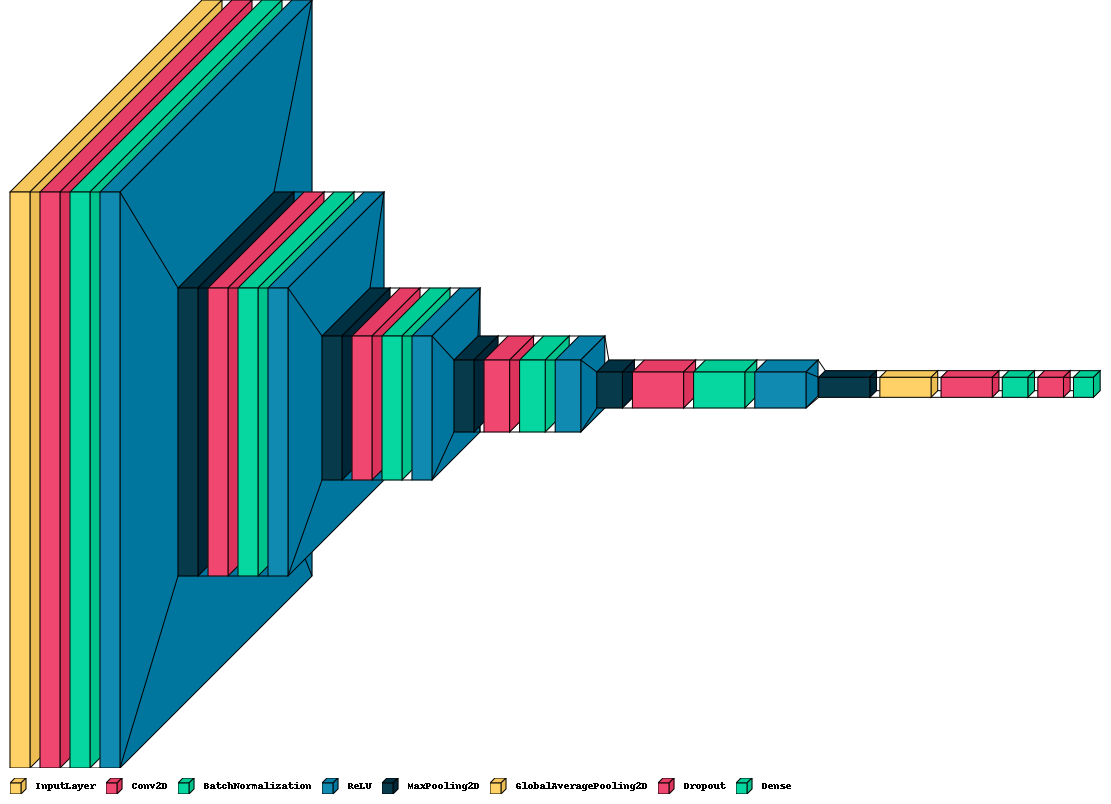

In [ ]:
display(visualkeras.layered_view(model, legend=True, scale_xy=6))

In [ ]:
# Train the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    class_weight = class_weights,
    batch_size = bs, 
    validation_data = valid_gen,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor=monmtr, patience=7, restore_best_weights=True),
).history

Epoch 1/200
45/45 [==============================] - 1078s 24s/step - loss: 2.0600 - accuracy: 0.2793 - val_loss: 6.7199 - val_accuracy: 0.0940
Epoch 2/200
45/45 [==============================] - 81s 2s/step - loss: 1.8432 - accuracy: 0.3415 - val_loss: 5.8718 - val_accuracy: 0.0513
Epoch 3/200
45/45 [==============================] - 81s 2s/step - loss: 1.7000 - accuracy: 0.3931 - val_loss: 2.1735 - val_accuracy: 0.1880
Epoch 4/200
45/45 [==============================] - 81s 2s/step - loss: 1.6307 - accuracy: 0.4033 - val_loss: 2.7620 - val_accuracy: 0.2678
Epoch 5/200
45/45 [==============================] - 82s 2s/step - loss: 1.5979 - accuracy: 0.4245 - val_loss: 2.1132 - val_accuracy: 0.2678
Epoch 6/200
45/45 [==============================] - 81s 2s/step - loss: 1.5255 - accuracy: 0.4443 - val_loss: 1.8936 - val_accuracy: 0.2934
Epoch 7/200
45/45 [==============================] - 81s 2s/step - loss: 1.5316 - accuracy: 0.4426 - val_loss: 2.2421 - val_accuracy: 0.2165
Epoch 8/20

## 2. Balanced dataset

The second trial was to train the network with a balanced training set 

In [ ]:
!ls balanced_dataset_1000

test  train  val


In [ ]:
dataset_dir = "balanced_dataset_1000"
bs = 64

In [ ]:
gens = define_generators(dataset_dir, bs, aug_generator)

train_gen = gens['train']
valid_gen = gens['val']
test_gen = gens['test']

train_target = train_gen.classes
val_target = valid_gen.classes
test_target = test_gen.classes

train_target_cat = tfk.utils.to_categorical(train_gen.classes)
val_target_cat = tfk.utils.to_categorical(valid_gen.classes)
test_target_cat = tfk.utils.to_categorical(test_gen.classes)

Found 8000 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.


In [ ]:
from sklearn.utils import  compute_class_weight
class_weights =  compute_class_weight(class_weight = "balanced",
                              classes = np.unique(train_target),
                              y = train_target)
class_weights = dict(zip(np.unique(train_gen.classes), class_weights))
class_weights

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}

### Visualize weights

Train classes: {0: 0.3534817956875221, 1: 0.3534817956875221, 2: 0.3534817956875221, 3: 0.3534817956875221, 4: 0.3534817956875221, 5: 0.3534817956875221, 6: 0.3534817956875221, 7: 0.3534817956875221}


Text(0.5, 1.0, 'Weights')

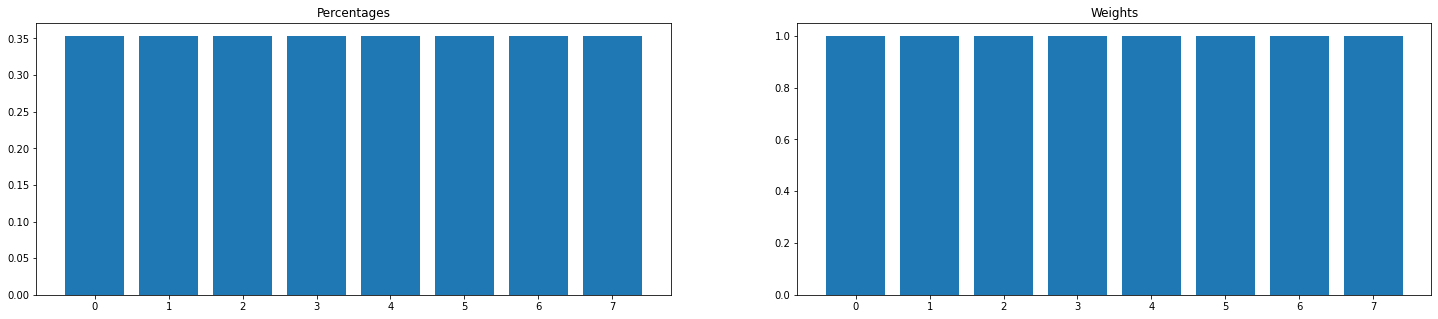

In [ ]:
unique, counts = np.unique(train_target, return_counts=True)
tc = dict(zip(unique, counts/2829))

print("Train classes: " + str(tc))

size, scale = 1000, 10
fig , (ax1 , ax2) = plt.subplots(1, 2, figsize=(25,5))
names = list(tc.keys())
values = list(tc.values())
ax1.bar(range(len(tc)), values, tick_label=names); ax1.set_title("Percentages")
names = list(class_weights.keys())
values = list(class_weights.values())
ax2.bar(range(len(class_weights)), values, tick_label=names); ax2.set_title("Weights")

### Training

In [ ]:
dropout_rate = 0.3
lr = 1e-3
l2 = 1e-5

In [ ]:
# Build model 
model = build_model_A(input_shape, dropout_rate, lr, l2)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        18496 

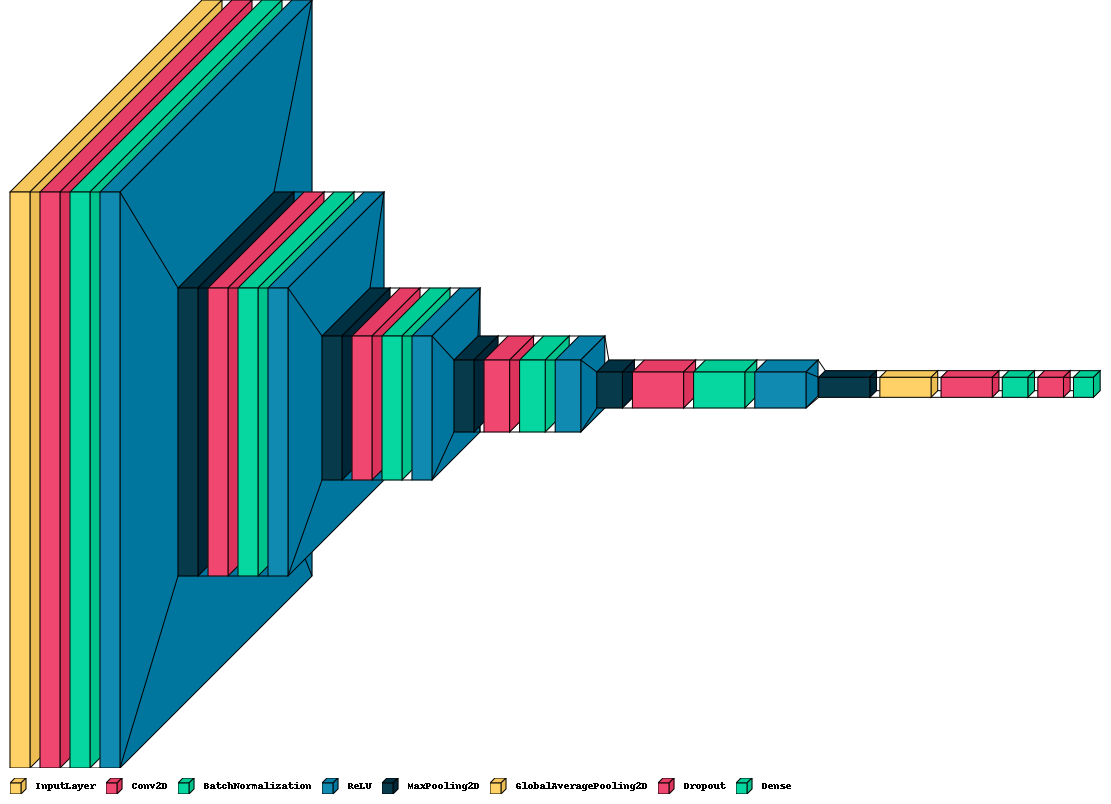

In [ ]:
display(visualkeras.layered_view(model, legend=True, scale_xy=6))

In [ ]:
# Train the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    #class_weight = class_weights,
    batch_size = bs, 
    validation_data = valid_gen,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor=monmtr, patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor=monmtr, patience=5, factor=0.5, min_lr=1e-5),
    ] 
).history

Epoch 1/200
125/125 [==============================] - 1426s 11s/step - loss: 1.9156 - accuracy: 0.2984 - val_loss: 4.3188 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 2/200
125/125 [==============================] - 34s 275ms/step - loss: 1.5955 - accuracy: 0.3996 - val_loss: 1.9873 - val_accuracy: 0.2821 - lr: 0.0010
Epoch 3/200
125/125 [==============================] - 35s 282ms/step - loss: 1.4486 - accuracy: 0.4543 - val_loss: 2.7066 - val_accuracy: 0.1937 - lr: 0.0010
Epoch 4/200
125/125 [==============================] - 34s 272ms/step - loss: 1.3730 - accuracy: 0.4775 - val_loss: 1.5637 - val_accuracy: 0.3476 - lr: 0.0010
Epoch 5/200
125/125 [==============================] - 35s 281ms/step - loss: 1.2870 - accuracy: 0.5146 - val_loss: 1.4789 - val_accuracy: 0.4302 - lr: 0.0010
Epoch 6/200
125/125 [==============================] - 35s 280ms/step - loss: 1.2450 - accuracy: 0.5344 - val_loss: 1.4114 - val_accuracy: 0.4387 - lr: 0.0010
Epoch 7/200
125/125 [=========================

In [ ]:
model.save("models/Trad_CNN_0")

# Training inspection and evaluation

Evaluation of the model and plot of Loss function and accuracy in train and validation over epochs

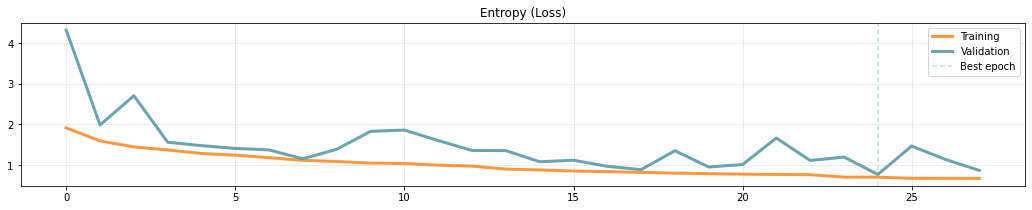

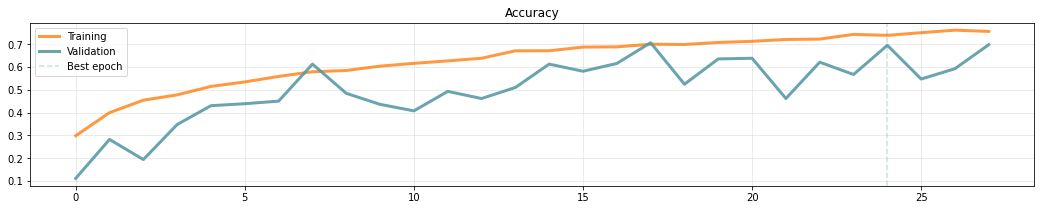

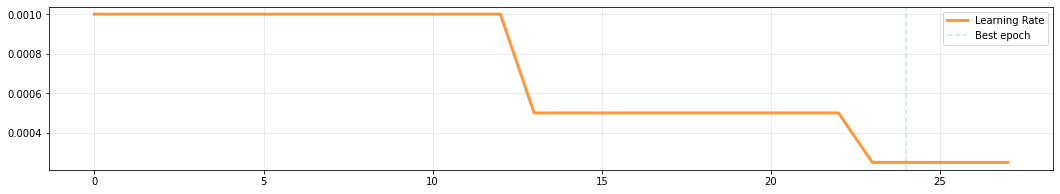

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(18,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Entropy (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()


plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

6/6 [==============================] - 165s 32s/step
Model: models/Trad_CNN_0
Accuracy: 0.6325966850828729
F1 score: 0.6150780749942836


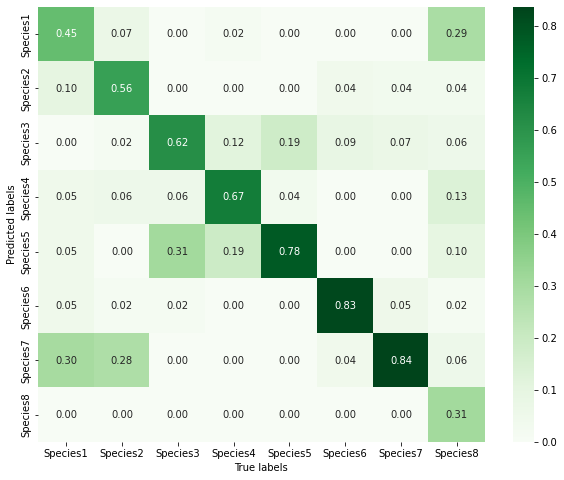

In [ ]:
res = evaluate_model("models/Trad_CNN_0", test_gen, test_target_cat) #best performing scratch model